#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import sklearn

In [ ]:
from sklearn.datasets import make_classification
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)

from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lbgm
import xgboost as xg

#Data Preprocessing Functions

In [ ]:
def data_loading(filename, v=True):
  data = pd.read_csv(filename) 
  #removing noisy data
  data = data.loc[data['speedup'] < 100]
  print("Shape of the CSV file is", data.shape)
  print("Columns found", data.columns)  
  return data


  

def drop_cols(data):
  cor_matrix = data.corr()
  # print(cor_matrix)

    

  fig, ax = plt.subplots(figsize=(20, 20))

  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  sns.heatmap(
      data=cor_matrix, 
      vmin=-1.0, 
      vmax=1.0, 
      center=0, 
      cmap=cmap, 
      square=True,
      linewidths=0.5, 
      linecolor='k',
      annot=True, 
      fmt='.2f',
      ax=ax
  )
  

  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
  ax.set_xticklabels(ax.get_yticklabels(), horizontalalignment='center')
  ax.set(title='Correlation Matrix (training data)')
  fig.savefig('heatmap.png')
  fig.show()

  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
  # print(upper_tri)
  to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

  print("Columns to drop:", to_drop)
  print("Columns to keepL", set(data.columns) - set(to_drop))
  
  return to_drop





def preprocessing(data, cols_to_drop=None, v = True):
  speedup_data = data['speedup']
  data = data.drop(cols_to_drop, axis=1)
  print("Name of all applications",pd.unique(data['application']))

  print("Number of rows of data", data.shape[0])

  print("Number of threads", pd.unique(data['thread_count']))

  print("threads vs count", data['thread_count'].value_counts())

  print("application vs count", data['application'].value_counts())

  data = data.drop(['exec_time','speedup','application'], axis =1)
 
  
  obj_df = data.select_dtypes(include=['object']).copy()
  ord_enc = OrdinalEncoder()
  obj_df["SizeNumerical"] = ord_enc.fit_transform(obj_df[["size"]])
  obj_df[["size", "SizeNumerical"]].head(11)

  # Remove the Size column now
  obj_df = obj_df.drop(['size'], axis=1)
  data =  data.drop(['size'], axis=1)

  # Insert the new column size into data frame
  data.insert(loc=1, column='app_size', value=obj_df)

  
  
  #min-max normalization
  scaler = MinMaxScaler()
  
  #Convert the data to numpy array
  X = data
  X= scaler.fit_transform(X)

  #Convert the speedup to numpy array
  Y = speedup_data.to_numpy()
  # Y =  scaler.fit_transform(Y.reshape(-1,1))
  

  # 20% test data and 80% training data
  test_size = 0.2
  
  print("Final columns for the dataset are",data.columns)
  
  # Prepare testing and training data
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, shuffle=True)

  return X_train, X_test, Y_train, Y_test



In [ ]:
import statsmodels.api as sm
from IPython.core.pylabtools import figsize

#Training Models

In [ ]:
cols = ['thread_count', 'app_size', 'branch-instructions', 'branch-misses',
       'cache-misses', 'cache-references', 'instructions', 'page-faults',
       'L1-dcache-load-misses', 'L1-icache-load-misses', 'cpu-migrations']

In [ ]:

def train_all_models(X_train, X_test, Y_train, Y_test, cols):

  print("Linear Regression\n")
  # Linear
  model = LinearRegression()
  model.fit(X_train,Y_train)

  predicted_exe_time = model.predict(X_test)
  MAE = sklearn.metrics.mean_absolute_error(Y_test , predicted_exe_time)
  print("R2 score",sklearn.metrics.r2_score(Y_test , predicted_exe_time))
  print('Linear Regression validation MAE: ', MAE)

  figsize(6.4,4.8)
  plt.scatter(predicted_exe_time, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))
  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("Linear Regression, MAE: "+str(MAE))
  plt.savefig("LinearRegression.png")
  plt.show()
  
  print()
  print()
  print()

  #KNN
  print("KNN\n")
  model = sklearn.neighbors.KNeighborsRegressor()
  model.fit(X_train,Y_train)
  predicted_exe_time = model.predict(X_test)
  MAE = sklearn.metrics.mean_absolute_error(Y_test , predicted_exe_time)
  print("R2 score",sklearn.metrics.r2_score(Y_test , predicted_exe_time))

  print('KNN validation MAE: ', MAE)
  figsize(6.4,4.8)
  plt.scatter(predicted_exe_time, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))
  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("KNN, MAE: "+str(MAE))
  plt.savefig("KNN.png")
  plt.show()

  print()
  print()
  print()
  
  #Ridge
  print("Ridge Regression\n")
  model = Ridge()
  model.fit(X_train,Y_train)
  predicted_exe_time = model.predict(X_test)
  MAE = sklearn.metrics.mean_absolute_error(Y_test , predicted_exe_time)
  print("R2 score",sklearn.metrics.r2_score(Y_test , predicted_exe_time))
  print('Ridge validation MAE: ', MAE)
  figsize(6.4,4.8)
  plt.scatter(predicted_exe_time, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))
  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("Ridge Regression, MAE: "+str(MAE))
  plt.savefig("RidgeRegression.png")
  plt.show()
  
  print()
  print()
  print()

  # Random forest Regression
  print("Random Forest\n")
  model_rf = RandomForestRegressor()
  model_rf.fit(X_train,Y_train)
  predicted_exe_time = model_rf.predict(X_test)
  print("R2 score",sklearn.metrics.r2_score(Y_test , predicted_exe_time))

  MAE = sklearn.metrics.mean_absolute_error(Y_test , predicted_exe_time)
  print('Random forest validation MAE: ', MAE)
  figsize(6.4,4.8)
  plt.scatter(predicted_exe_time, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))
  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("Random Forest, MAE: "+str(MAE))
  plt.savefig("RandomForest.png")
  plt.show()

  print()
  importance = model_rf.feature_importances_
  # summarize feature importance
  for i,v in enumerate(importance):
    print('Feature: %0d, Name: %s Score: %.5f' % (i,cols[i],v ))
  print()
  # plot feature importance
  figsize(30,7)
  plt.bar([cols[x] for x in range(len(importance))], importance)
  plt.title("Random Forest Feature Importance")
  plt.savefig("random_forest_features.png")
  plt.show()
  
  print()
  print()
  print()

  # Gradient Boost Regression
  print("Gradient Boosting\n")
  model_gb = sklearn.ensemble.GradientBoostingRegressor()
  model_gb.fit(X_train,Y_train)
  predicted_exe_time = model_gb.predict(X_test)
  MAE = sklearn.metrics.mean_absolute_error(Y_test , predicted_exe_time)
  print("R2 score",sklearn.metrics.r2_score(Y_test , predicted_exe_time))

  print('Gradient Boost validation MAE: ', MAE)
  figsize(6.4,4.8)
  plt.scatter(predicted_exe_time, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))
  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("Gradient Boosting, MAE: "+str(MAE))
  plt.savefig("GradientBoosting.png")
  plt.show()
  print()
  importance = model_gb.feature_importances_
  # summarize feature importance
  for i,v in enumerate(importance):
    print('Feature: %0d, Name: %s Score: %.5f' % (i,cols[i],v ))
  # plot feature importance
  print()
  figsize(30,7)
  plt.title("Gradient Boosting Feature Importance")
  plt.bar([cols[x] for x in range(len(importance))], importance)
  plt.savefig("gradient_boosting_features.png")
  plt.show()
  print()
  print()
  print()

  # Ada Boost Regression
  print("Ada Boosting\n")
  model = AdaBoostRegressor()
  model.fit(X_train,Y_train)
  predicted_exe_time = model.predict(X_test)
  MAE = sklearn.metrics.mean_absolute_error(Y_test , predicted_exe_time)
  figsize(6.4,4.8)
  print('Ada Boost validation MAE: ', MAE)
  print("R2 score",sklearn.metrics.r2_score(Y_test , predicted_exe_time))
  plt.scatter(predicted_exe_time, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))
  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("Ada Boost, MAE: "+str(MAE))
  plt.savefig("adaboost.png")
  plt.show()
  print()
  print()
  print()
  from sklearn.tree import DecisionTreeRegressor
  model = DecisionTreeRegressor()
  model.fit(X_train,Y_train)
  predicted_exe_time = model.predict(X_test)
  MAE = sklearn.metrics.mean_absolute_error(Y_test , predicted_exe_time)
  print("R2 score",sklearn.metrics.r2_score(Y_test , predicted_exe_time))

  figsize(6.4,4.8)
  print('Decision Tree validation MAE: ', MAE)
  plt.scatter(predicted_exe_time, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))

  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("Decision Tree, MAE: "+str(MAE))
  plt.savefig("decisiontree.png")
  plt.show()

  print()
  print()
  print()



  # Determination of the kernel used and the value lenght_scale at which the optimization process starts
  print("Gaussian Process\n")
  kernel = DotProduct() + WhiteKernel()
  # Application of the regressor (alpha makes a statement about a possible noise of the training data)
  gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
  gp.fit(X_train, Y_train)

  # Prediction of the dependent variable for the test dataset
  predicted_exe_time, sigma = gp.predict(X_test, return_std=True)
  MAE = sklearn.metrics.mean_absolute_error(Y_test , predicted_exe_time)
  print('Gaussian validation MAE: ', MAE)  
  print("R2 score",sklearn.metrics.r2_score(Y_test , predicted_exe_time))

 
  figsize(6.4,4.8)
  plt.scatter(predicted_exe_time, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))
  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("Gaussian , MAE: "+str(MAE))
  plt.savefig("Gaussian.png")
  plt.show()

  print()
  print()
  print()

  print("XG Boosting\n")
  model = xg.XGBRegressor()
  model.fit(X_train,Y_train)
  predicted_exe_time = model.predict(X_test)
  MAE = sklearn.metrics.mean_absolute_error(Y_test , predicted_exe_time)
  figsize(6.4,4.8)
  print('XG Boost validation MAE: ', MAE)
  print("R2 score",sklearn.metrics.r2_score(Y_test , predicted_exe_time))

  plt.scatter(predicted_exe_time, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))
  
  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("XG Boost, MAE: "+str(MAE))
  plt.savefig("xgboost.png")
  plt.show()
  print()
  importance = model.feature_importances_
  # summarize feature importance
  for i,v in enumerate(importance):
    print('Feature: %0d, Name: %s Score: %.5f' % (i,cols[i],v ))
  print()
  # plot feature importance
  figsize(30,7)
  plt.title("XGBoost Feature Importance")
  
  plt.bar([cols[x] for x in range(len(importance))], importance)
  plt.savefig("xgboost_features.png")
  plt.show()
  print()
  print()
  print()

Shape of the CSV file is (464, 25)
Columns found Index(['application', 'size', 'thread_count', 'exec_time', 'speedup',
       'branch-instructions', 'branch-miss-rate', 'branch-misses',
       'cache-miss-rate', 'cache-misses', 'cache-references', 'cycles', 'ipc',
       'instructions', 'cpu-clock', 'page-faults', 'L1-dcache-loads',
       'L1-dcache-load-misses', 'L1-icache-loads', 'L1-icache-load-misses',
       'LLC-loads', 'LLC-load-misses', 'branch-load-misses',
       'context-switches', 'cpu-migrations'],
      dtype='object')
Columns to drop: ['branch-miss-rate', 'cache-miss-rate', 'cycles', 'ipc', 'cpu-clock', 'L1-dcache-loads', 'L1-icache-loads', 'LLC-loads', 'LLC-load-misses', 'branch-load-misses', 'context-switches']
Columns to keepL {'branch-misses', 'size', 'exec_time', 'speedup', 'cache-misses', 'cpu-migrations', 'cache-references', 'branch-instructions', 'L1-dcache-load-misses', 'thread_count', 'application', 'page-faults', 'L1-icache-load-misses', 'instructions'}
Name 

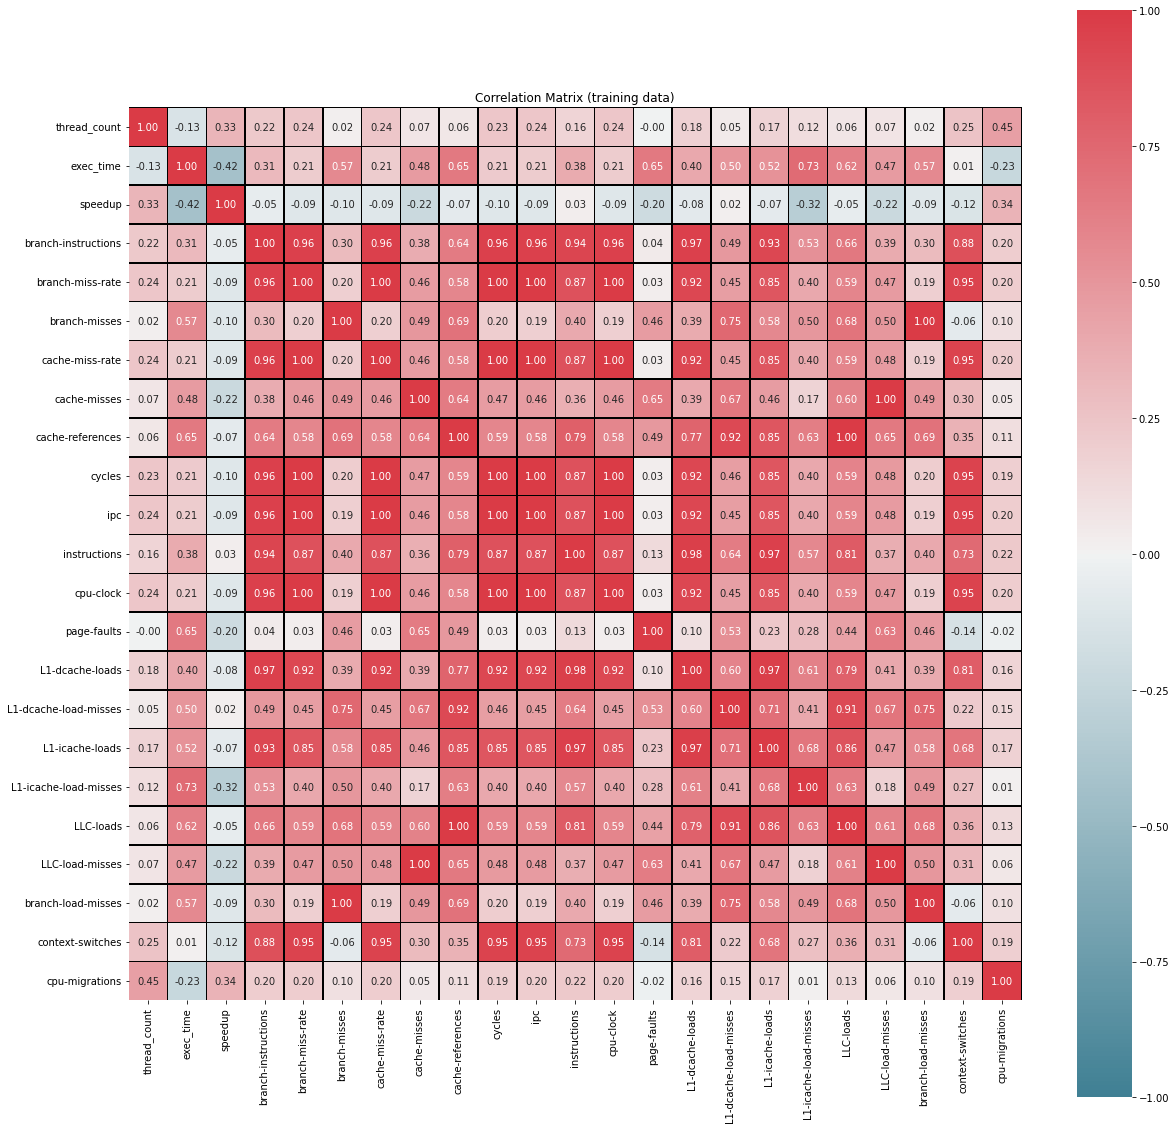

In [ ]:

data = data_loading("output_complete_without_native_with_new_cols.csv")

to_drop = drop_cols(data)

#with dropping
X_train, X_test, Y_train, Y_test = preprocessing(data, cols_to_drop=to_drop)

Linear Regression

R2 score 0.5207769404641855
Linear Regression validation MAE:  1.9414255627406152


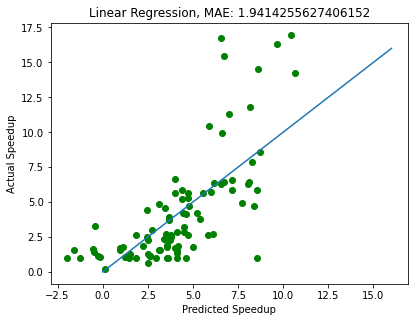




KNN

R2 score 0.8558409470159721
KNN validation MAE:  0.9163176371221552


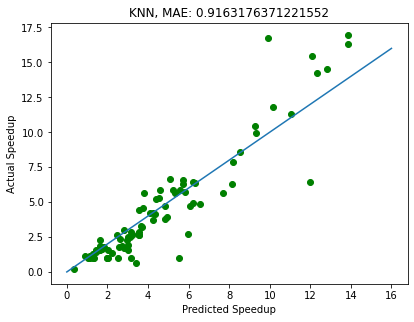




Ridge Regression

R2 score 0.5265414416423078
Ridge validation MAE:  1.9050105065325784


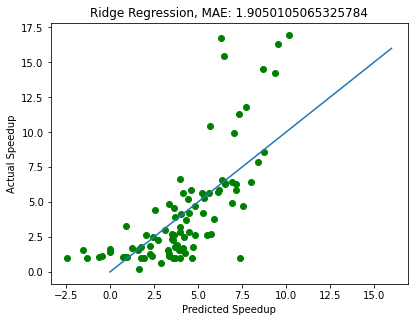




Random Forest

R2 score 0.9646731729880299
Random forest validation MAE:  0.4220224119959018


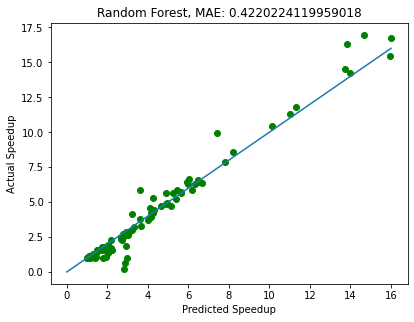


Feature: 0, Name: thread_count Score: 0.32690
Feature: 1, Name: app_size Score: 0.00824
Feature: 2, Name: branch-instructions Score: 0.04926
Feature: 3, Name: branch-misses Score: 0.07457
Feature: 4, Name: cache-misses Score: 0.08178
Feature: 5, Name: cache-references Score: 0.02206
Feature: 6, Name: instructions Score: 0.06141
Feature: 7, Name: page-faults Score: 0.19834
Feature: 8, Name: L1-dcache-load-misses Score: 0.02052
Feature: 9, Name: L1-icache-load-misses Score: 0.05003
Feature: 10, Name: cpu-migrations Score: 0.10689



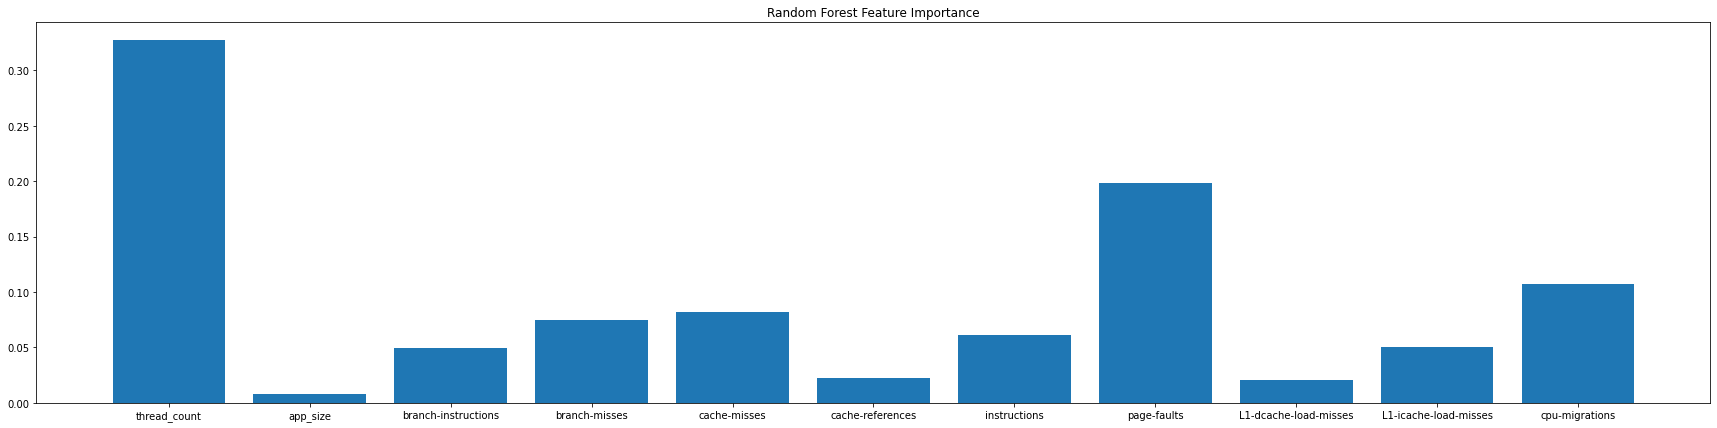




Gradient Boosting

R2 score 0.9394126454176129
Gradient Boost validation MAE:  0.7209094214574975


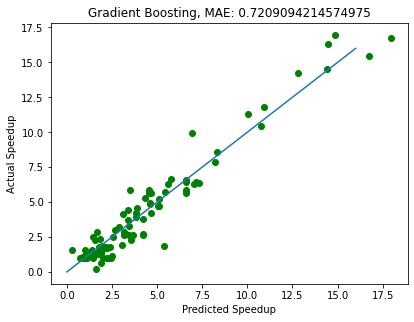


Feature: 0, Name: thread_count Score: 0.36070
Feature: 1, Name: app_size Score: 0.02233
Feature: 2, Name: branch-instructions Score: 0.02173
Feature: 3, Name: branch-misses Score: 0.05595
Feature: 4, Name: cache-misses Score: 0.10908
Feature: 5, Name: cache-references Score: 0.01009
Feature: 6, Name: instructions Score: 0.11161
Feature: 7, Name: page-faults Score: 0.15527
Feature: 8, Name: L1-dcache-load-misses Score: 0.00483
Feature: 9, Name: L1-icache-load-misses Score: 0.05636
Feature: 10, Name: cpu-migrations Score: 0.09205



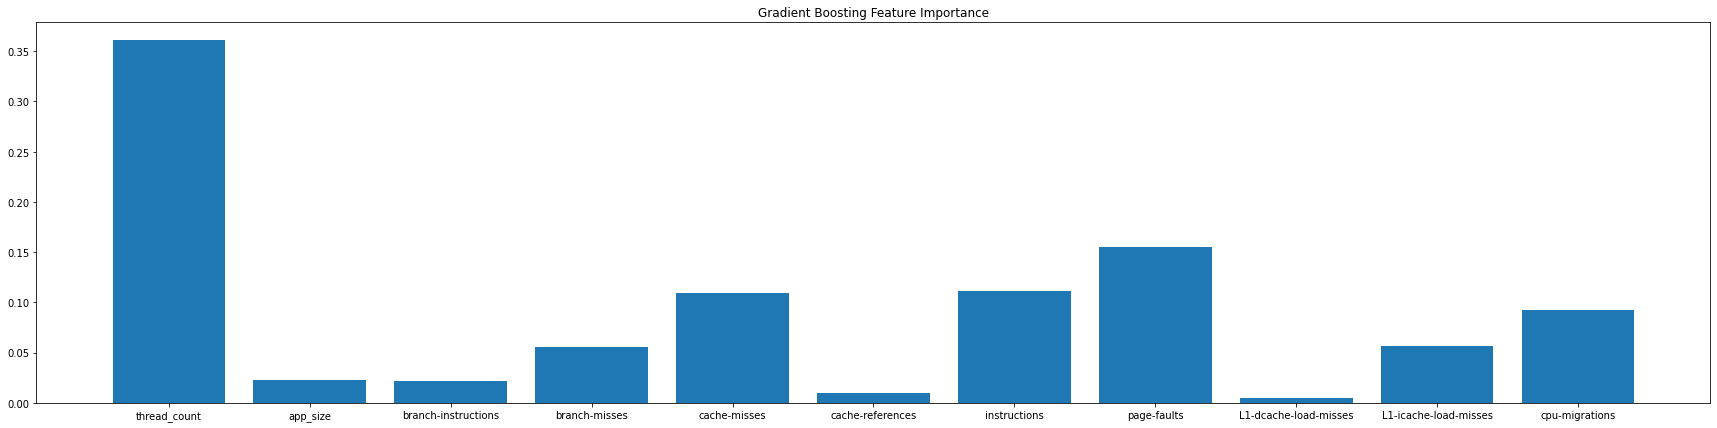




Ada Boosting

Ada Boost validation MAE:  1.3251976079811447
R2 score 0.8290329854232957


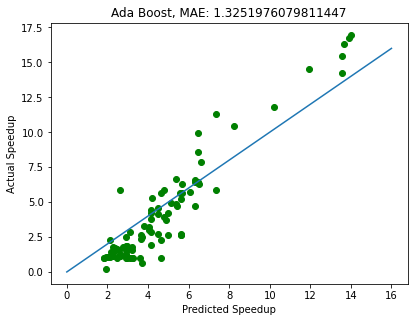




R2 score 0.9455591532784918
Decision Tree validation MAE:  0.496806836706341


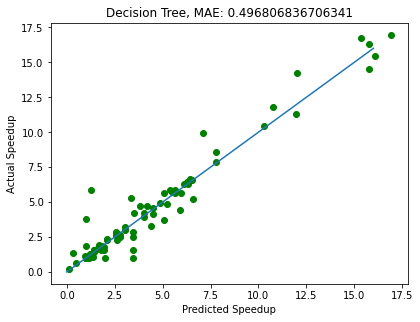




Gaussian Process

Gaussian validation MAE:  1.9822212532916614
R2 score 0.4493130673172314


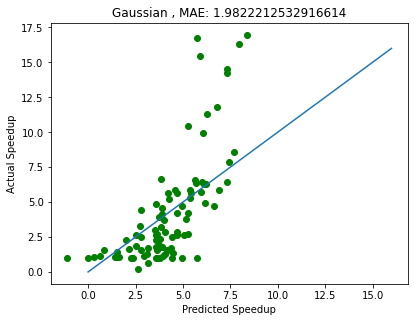




XG Boosting

[17:55:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG Boost validation MAE:  0.6295049671034267
R2 score 0.9559826309508318


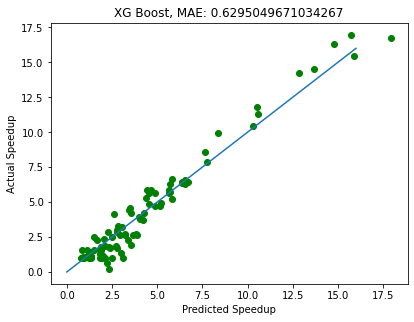


Feature: 0, Name: thread_count Score: 0.20028
Feature: 1, Name: app_size Score: 0.10940
Feature: 2, Name: branch-instructions Score: 0.01507
Feature: 3, Name: branch-misses Score: 0.13996
Feature: 4, Name: cache-misses Score: 0.10238
Feature: 5, Name: cache-references Score: 0.01984
Feature: 6, Name: instructions Score: 0.05315
Feature: 7, Name: page-faults Score: 0.13861
Feature: 8, Name: L1-dcache-load-misses Score: 0.03230
Feature: 9, Name: L1-icache-load-misses Score: 0.06547
Feature: 10, Name: cpu-migrations Score: 0.12353



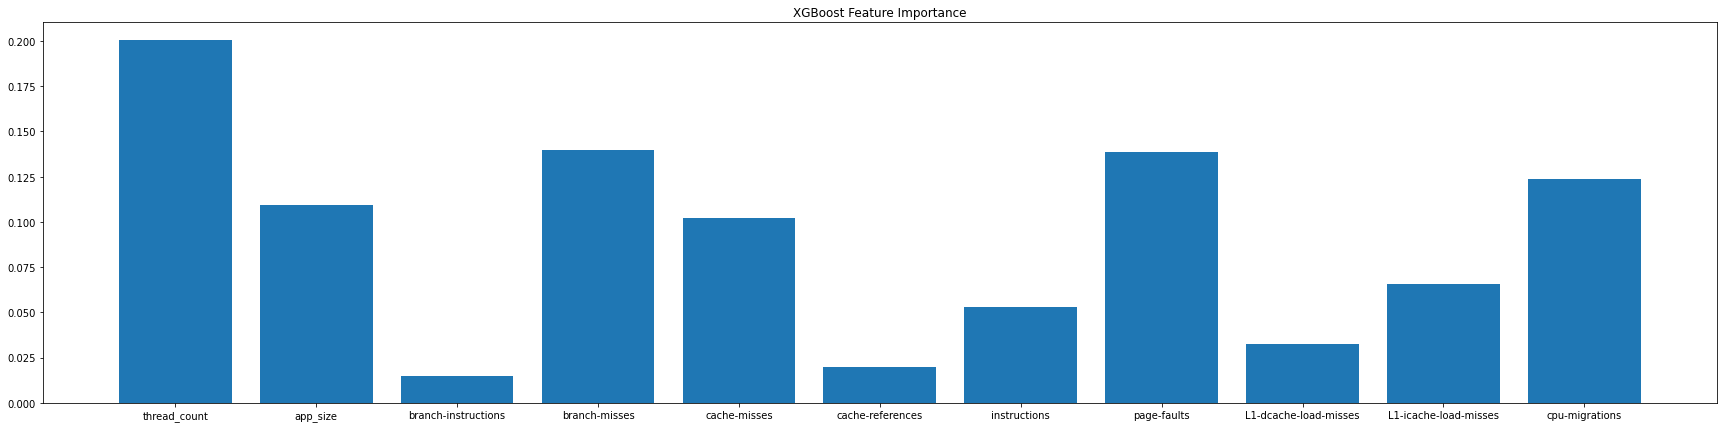

In [ ]:
train_all_models(X_train, X_test, Y_train, Y_test,cols)

In [ ]:
print(X_train.size, X_test.size)

4081 1023


In [ ]:
print(len(X_train), len(X_test))

371 93


#Grid Search: REDO

In [ ]:
def grid_search(X_train, X_test, Y_train, Y_test):
  
  # Number of trees in random forest
  n_estimators = [100,1000,200,300,500]

  # Minimum number of samples required to split a node
  min_samples_split = [2, 5,10]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [1, 2]
 

    # Create the random grid
  random_grid = {'n_estimators': n_estimators,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf
                }

  # Use the random grid to search for best hyperparameters
  # First create the base model to tune
  rf = RandomForestRegressor()
  # Random search of parameters, using 3 fold cross validation, 
  # search across 100 different combinations, and use all available cores
  rf_random= GridSearchCV( estimator = rf, param_grid =random_grid, verbose=3, cv=2, scoring='neg_mean_absolute_error')
  # Fit the random search model
  rf_random.fit(X_train, Y_train)


  
  print("Best parameters found:", rf_random.best_params_)
  best_random = rf_random.best_estimator_
  predictions_ran = best_random.predict(X_test)
  errors_ran = sklearn.metrics.mean_absolute_error(Y_test, predictions_ran)
  print("R2 score",sklearn.metrics.r2_score(Y_test , predictions_ran))


  # print('Improvement of {:0.2f}%.'.format( 100 * (errors - errors_ran) / errors))
  print('GridSearch validation MAE: ', errors_ran)
  figsize(6.4,4.8)
  plt.scatter(predictions_ran, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))
  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("Grid Search Best Model, MAE: "+str(errors_ran))
  plt.savefig("gridsearchbest.png")
  plt.show()

  print()

 

  return rf_random

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV 1/2] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.949 total time=   0.2s
[CV 2/2] END min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.914 total time=   0.2s
[CV 1/2] END min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=-0.909 total time=   2.0s
[CV 2/2] END min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=-0.914 total time=   2.0s
[CV 1/2] END min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.954 total time=   0.4s
[CV 2/2] END min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.919 total time=   0.4s
[CV 1/2] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=-0.948 total time=   0.6s
[CV 2/2] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=-0.923 total time=   0.6s
[CV 1/2] END min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=-0.937 total time=

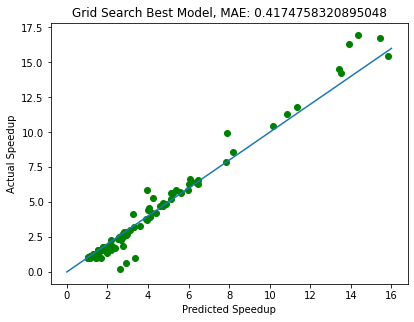

In [ ]:
rf_random = grid_search(X_train, X_test, Y_train, Y_test)

In [ ]:
import pandas as pd

results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1_2_1000,"{'min_samples_leaf': 1, 'min_samples_split': 2...",1,-0.911485,0.002304
1_2_500,"{'min_samples_leaf': 1, 'min_samples_split': 2...",2,-0.931370,0.005812
1_2_100,"{'min_samples_leaf': 1, 'min_samples_split': 2...",3,-0.931399,0.017852
1_2_300,"{'min_samples_leaf': 1, 'min_samples_split': 2...",4,-0.935530,0.012553
1_2_200,"{'min_samples_leaf': 1, 'min_samples_split': 2...",5,-0.936882,0.017464
1_5_200,"{'min_samples_leaf': 1, 'min_samples_split': 5...",6,-0.942769,0.000431
2_5_300,"{'min_samples_leaf': 2, 'min_samples_split': 5...",7,-0.945933,0.018835
2_2_200,"{'min_samples_leaf': 2, 'min_samples_split': 2...",8,-0.956200,0.033331
1_5_1000,"{'min_samples_leaf': 1, 'min_samples_split': 5...",9,-0.959755,0.005443


#Ensemble: BEST MODEL

In [ ]:
from xgboost.sklearn import XGBRFRegressor
def train_ensemble(X_train, X_test, Y_train, Y_test ):
  models = [RandomForestRegressor(min_samples_leaf= 1, min_samples_split= 2, n_estimators= 500),RandomForestRegressor(min_samples_leaf= 1, min_samples_split= 2,n_estimators=200),RandomForestRegressor(min_samples_leaf= 1, min_samples_split= 2,n_estimators=1000)]
  total_preds =[]
  for i in models:
    i.fit(X_train, Y_train)
    preds = i.predict(X_test)
    total_preds.append(preds)
  
  final_preds = []
  for i in range(len(total_preds[0])):
    t=0
    for j in range(len(total_preds)):
      t += total_preds[j][i]
    final_preds.append(float(t/3))
  
  print("MAE:", mean_absolute_error(final_preds, Y_test))
  figsize(6.4,4.8)
  plt.scatter(final_preds, Y_test, c="g")
  plt.plot(range(int(max(Y_test)) + 1))
  plt.xlabel('Predicted Speedup')
  plt.ylabel('Actual Speedup')
  plt.title("Ensemble, MAE:"+str(mean_absolute_error(final_preds, Y_test)))
  plt.savefig("Ensemble.png")
  plt.show()

MAE: 0.40122782751210667


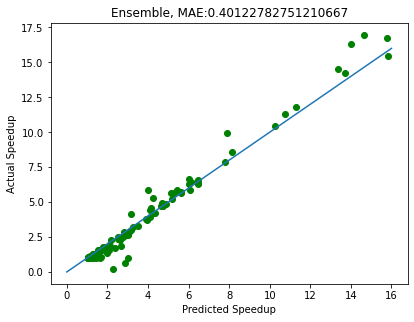

In [ ]:
train_ensemble(X_train, X_test, Y_train, Y_test)